# Face Recognization Model

- Python 3.7.10
- Tensorflow 2.5.0
- Keras 2.4.3
<br><br>
- One Shot Model
- Siamese Network
- Data preprocessing
- Modeling

> # I. Import

> ## 1) Import packages


In [ ]:
# from google.colab import drive
# from google.colab.patches import cv2_imshow

import os
import cv2
import numpy as np
import random
from PIL import Image
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from keras import backend as K
from keras.models import load_model, Sequential, Model
from keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Input, Lambda
from keras.preprocessing.image import load_img, img_to_array, array_to_img

> ## 2) Functions

- Normalization
    - 데이터 전처리 방식의 하나로 추가했던 코드
    - validation_accuracy의 증가는 있었으나 실제 동일인을 판별하는 부분에 있어서 output이 좋지 않았음

In [ ]:
# def normal_2(img_path) :
#     # read image as grayscale float in range 0 to 1
#     img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE).astype(np.float64) / 255.0

#     # set arguments
#     gamma = 0.2
#     alpha = 0.1
#     tau = 3.0

#     # gamma correction
#     img_gamma = np.power(img, gamma)
#     img_gamma2 = (255.0 * img_gamma).clip(0,255).astype(np.uint8)

#     # DOG
#     blur1 = cv2.GaussianBlur(img_gamma, (0,0), 1, borderType=cv2.BORDER_REPLICATE)
#     blur2 = cv2.GaussianBlur(img_gamma, (0,0), 2, borderType=cv2.BORDER_REPLICATE)
#     img_dog = (blur1 - blur2)
#     # normalize by the largest absolute value so range is -1 to 
#     img_dog = img_dog / np.amax(np.abs(img_dog))
#     img_dog2 = (255.0 * (0.5*img_dog + 0.5)).clip(0,255).astype(np.uint8)

#     # contrast equalization equation 1
#     img_contrast1 = np.abs(img_dog)
#     img_contrast1 = np.power(img_contrast1, alpha)
#     img_contrast1 = np.mean(img_contrast1)
#     img_contrast1 = np.power(img_contrast1,1.0/alpha)
#     img_contrast1 = img_dog/img_contrast1

#     # contrast equalization equation 2
#     img_contrast2 = np.abs(img_contrast1)
#     img_contrast2 = img_contrast2.clip(0,tau)
#     img_contrast2 = np.mean(img_contrast2)
#     img_contrast2 = np.power(img_contrast2,1.0/alpha)
#     img_contrast2 = img_contrast1/img_contrast2
#     img_contrast = tau * np.tanh((img_contrast2/tau))

#     # Scale results two ways back to uint8 in the range 0 to 255
#     img_contrastA = (255.0 * (img_contrast+0.5)).clip(0,255).astype(np.uint8)

#     return img_contrastA

- 유클리디안 거리
    - 평면 상에 임베딩 된 두 이미지의 거리를 측정하기 위한 함수

In [ ]:
def euclidean_distance(vectors):
    vector1, vector2 = vectors
    sum_square = K.sum(K.square(vector1 - vector2), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))

- 대조 손실 함수
    - 레이블링과 결과가 동일하지 않을 경우 효과적으로 가중치를 업데이트 하기 위한 함수

In [ ]:
def contrastive_loss(Y_true, D):
    Y_true= tf.cast (Y_true, tf.float32)
    margin = 1
    return K.mean(Y_true * K.square(D) + (1 - Y_true) * K.maximum((margin-D),0))

- 모델 학습용 이미지 전처리

In [ ]:
def image_processing(img):
    img = load_img(img)
    img = img_to_array(img).astype('float32') / 255
    img = cv2.resize(img, (100, 100))  # 사진 봐서 바꾸기
    ## 흑백일 경우 적용 코드
#     img = img.reshape(img.shape[0], img.shape[1], 1)
#     img = np.expand_dims(img, axis=0)

    return img

- 모델 학습용 데이터셋 생성

In [ ]:
def create_pairs(X,Y, num_classes):
    pairs, labels = [], []
    # index of images in X and Y for each class
    class_idx = [np.where(Y==i)[0] for i in range(num_classes)]
    # The minimum number of images across all classes
    min_images = min(len(class_idx[i]) for i in range(num_classes)) - 1
  
    for c in range(num_classes):
        for n in range(min_images):
            # create positive par
            img1 = X[class_idx[c][n]]
            img2 = X[class_idx[c][n+1]]
            pairs.append((img1, img2))
            labels.append(1)
      
            # create negative pair
            # first, create list of classes that are different from the current class
            neg_list = list(range(num_classes))
            neg_list.remove(c)
            # select a random class from the negative list. 
            # this class will be used to form the negative pair
            neg_c = random.sample(neg_list,1)[0]
            img1 = X[class_idx[c][n]]
            img2 = X[class_idx[neg_c][n]]
            pairs.append((img1,img2))
            labels.append(0)

    return np.array(pairs), np.array(labels)

- Siamese Network 생성을 위해 모델 구조를 함수로 생성

In [ ]:
def create_shared_network(input_shape):
    model = Sequential(name='Shared_Conv_Network')
    model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D())
    model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
    model.add(Flatten())
    model.add(Dense(units=128, activation='sigmoid'))
    return model

-  정확도 측정 함수

In [ ]:
def accuracy(y_true, y_pred):
    return K.mean(K.equal(y_true, K.cast(y_pred < 0.5, y_true.dtype)))

> ## 3) Import drive & data

- Google Drive 연동

In [ ]:
drive.mount('/content/drive')

/home/lab10/SmartCCTV


- unzip data

In [ ]:
# !unzip '/home/lab10/data/L1_face_color.zip'

- 데이터 확인을 위한 경로 지정

In [ ]:
origin_path = '/home/lab10/SmartCCTV/L1_face_color/'
subfolders = sorted([file.path for file in os.scandir(origin_path)])

In [ ]:
len(subfolders)

209

<class 'numpy.ndarray'>
AxesImage(54,36;334.8x217.44)


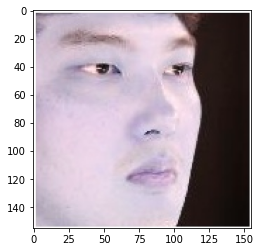

In [ ]:
dir = origin_path + '1/User.1.jpg'
img = cv2.imread(dir)
print(type(img))
print(plt.imshow(img))

> # II. Preprocessing

> ## 1) prepare dataset

- 원본 데이터 : 최상위 폴더 밑에 사람별 다른 각도로 촬영된 사진
- 처리 후 데이터 : [[사람1 얼굴 이미지들],[사람2 얼굴 이미지들],[사람3 얼굴 이미지들]....]
    - 각각의 이미지는 rotate_angle값에 따라 회전된 이미지로 Augmentation시켜 저장

In [ ]:
%%time
img_all = []
# 갯수 조절
range_number = 100 #6:2:2로 나누기 때문에 10의 배수로 조절해야함
rotate_angle = int(60)
rotate_number = int(360 / rotate_angle)

# Colab에서 실행 시 첫번째 for문의 range, 세번째 포문의 range, rotate 각도를 변경해가면서 테스트 해야함 
# RAM이 터져나가서 갯수조절필요
# range안에 원래 이거 들어감 : len(subfolders)
for idx1 in range(0,int(range_number)):
    img = sorted([file.path for file in os.scandir(subfolders[idx1])])
    img_normal_list = []

    for idx2, file in enumerate(img):
        for i in range(0,int(rotate_number)):
            img = Image.open(file)
            img_augmentation = img.rotate(i*(rotate_angle), fillcolor = 'black')
            img_augmentation = np.array(img_augmentation).astype('float32')/255

            img_normal_list.append(img_augmentation)
        # break
    img_all.append(img_normal_list)
    # break

CPU times: user 11.8 s, sys: 1.99 s, total: 13.8 s
Wall time: 13.8 s


- 확인용 코드

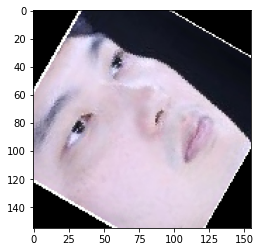

In [ ]:
plt.imshow(img_all[0][1])

In [ ]:
img_all[0][1].shape

(155, 155, 3)

- 앞서 만든 리스트를 Train, Validation, Test데이터로 분리
    - 데이터를 통일하기 위해 비율대로 앞에서부터 자름
    - 학습을 위해 데이터 크기 통일
        - 학습 데이터 갯수 증강을 위해 이미지 크기를 조정
        - (200,200) >> (100,100)

In [ ]:
X_train, Y_train = [], []
X_test, Y_test = [], []
X_valid, Y_valid = [], []

for idx, folder in enumerate(img_all):
    for file in folder:
        img = cv2.resize(file, (100, 100)) # 사진 봐서 바꿔야함
        # img = img.reshape(img.shape[0], img.shape[1], 1)

        if idx < (range_number*0.6):
            X_train.append(img)
            Y_train.append(idx)
        elif (range_number * 0.6) <= idx < (range_number * 0.8):
            X_valid.append(img)
            Y_valid.append(idx - (range_number*0.6))
        else:
            X_test.append(img)
            Y_test.append(idx-(range_number*0.8))

X_train = np.array(X_train)
X_test = np.array(X_test)
X_valid = np.array(X_valid)
Y_valid = np.array(Y_valid)
Y_train = np.array(Y_train)
Y_test = np.array(Y_test)

- 데이터 확인용 코드

In [ ]:
num_classes1 = len(np.unique(Y_train))
num_classes2 = len(np.unique(Y_valid))
num_classes3 = len(np.unique(Y_test))

In [ ]:
print(num_classes1)
print(num_classes2)
print(num_classes3)

60
20
20


- Train, Validation 데이터쌍 생성

In [ ]:
# Train the model
training_pairs, training_labels = create_pairs(X_train, Y_train, num_classes=num_classes1)
validation_pairs, validation_labels = create_pairs(X_valid, Y_valid, num_classes=num_classes2)

In [ ]:
print(training_pairs.shape)
print(training_labels.shape)
print(validation_pairs.shape)
print(validation_labels.shape)

(9240, 2, 100, 100, 3)
(9240,)
(3080, 2, 100, 100, 3)
(3080,)


> ## 2) prepare model

- shape 지정 및 1차 모델 아키텍처 생성

In [ ]:
input_shape = X_train.shape[1:]

shared_network = create_shared_network(input_shape)

In [ ]:
input_shape

(100, 100, 3)

- Siamese 네트워크 구조 생성

In [ ]:
input_top = Input(shape=input_shape)
input_bottom = Input(shape=input_shape)

In [ ]:
output_top = shared_network(input_top)
output_bottom = shared_network(input_bottom)

- Euclidean distance Layer 추가

In [ ]:
distance = Lambda(euclidean_distance, output_shape=(1,))([output_top, output_bottom])

- 메모리 최적화를 위해 불필요한 데이터 생성

In [ ]:
img_all = []
img_normal_list = []
X_train = []
X_test = []
Y_train = []
Y_test = []

> # III. Model

> ## 1) Model define

- 모델 생성

In [ ]:
model = Model(inputs=[input_top, input_bottom], outputs=distance)

- 모델 확인

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
Shared_Conv_Network (Sequential (None, 128)          18134976    input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 1)            0           Shared_Conv_Network[0][0]    

- 모델 컴파일

In [ ]:
# model compile
# use functions
model.compile(loss=contrastive_loss, optimizer='adam', metrics=[accuracy]) 

- EarlyStopping, ModelCheckpoint 설정

In [ ]:
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=2)
mc = ModelCheckpoint('MC_project_final.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

> ## 2) Model fit

In [ ]:
%%time

tf.keras.initializers.HeNormal()

hist = model.fit([training_pairs[:, 0], training_pairs[:, 1]], training_labels,
                batch_size=32,
                epochs=50,
                callbacks = [es, mc],
                validation_data = ([validation_pairs[:, 0], validation_pairs[:, 1]], validation_labels))

Epoch 1/50
289/289 [==============================] - 19s 58ms/step - loss: 0.2173 - accuracy: 0.7811 - val_loss: 0.2854 - val_accuracy: 0.7136

Epoch 00001: val_accuracy improved from -inf to 0.71360, saving model to MC_project_final.h5
Epoch 2/50
289/289 [==============================] - 15s 52ms/step - loss: 0.3483 - accuracy: 0.6484 - val_loss: 0.4998 - val_accuracy: 0.5000

Epoch 00002: val_accuracy did not improve from 0.71360
Epoch 3/50
289/289 [==============================] - 15s 52ms/step - loss: 0.4996 - accuracy: 0.5003 - val_loss: 0.4998 - val_accuracy: 0.5000

Epoch 00003: val_accuracy did not improve from 0.71360
Epoch 00003: early stopping
CPU times: user 41.4 s, sys: 12.8 s, total: 54.2 s
Wall time: 53.3 s


> ## 3) Model save

- 저장 모델명 지정을 위한 val_accuracy값 저장

In [ ]:
max_compare = "{:.3f}".format(float(max(hist.history['val_accuracy'])) * 100)

In [ ]:
# 저장 경로 변경
%cd /home/lab10/

/home/lab10


In [ ]:
# Save the model
model.save('MC_project_final_'+ str(range_number) + "_" + str(max_compare) + '%' + '.h5')

> ## 4) Model test in Real

- Test용 이미지 압축 해제를 위한 경로 변경

In [ ]:
%cd '/content/'

[Errno 2] No such file or directory: '/content/'
/home/lab10


In [ ]:
# !unzip '/home/lab10/data/face_test.zip'

- 테스트 데이터 경로 지정 및 모델 로드

In [ ]:
face_path1 = '/home/lab10/User/'
face_path2 = '/home/lab10/Visit/'
model_path = '/home/lab10/'

model = load_model(model_path + 'MC_project_final_'+ str(range_number) + "_" + str(max_compare) + '%' + '.h5', 
                   custom_objects={'contrastive_loss': contrastive_loss, 
                                   'euclidean_distance': euclidean_distance})

- 테스트 이미지 비교

In [ ]:
idx1 = face_path1 + '2_user_female.jpg'
idx2 = face_path2 + '20.jpg'

# idx1 = cv2.imread(idx1)
# idx2 = cv2.imread(idx2)

# 모델에 집어넣기 위해 한차원 확장해줌
img1 = np.expand_dims(image_processing(idx1), axis=0)
img2 = np.expand_dims(image_processing(idx2), axis=0)

# 그림 두개 비교 왼쪽이 img1 오른쪽이 img2
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,7))
ax1.imshow(np.squeeze(img1), cmap='gray')
ax2.imshow(np.squeeze(img2), cmap='gray')

for ax in [ax1, ax2]:
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])

# 두 얼굴 사이의 유클리디안 거리. 왜 맨 위에 나오지?
dissimilarity = model.predict([img1, img2])[0][0]
fig.suptitle("Dissimilarity Score = {:.6f}".format(dissimilarity), size = 30)
plt.tight_layout()
plt.show()